In [1]:
%load_ext autoreload
%autoreload 2

import sys,glob,os,errno

import numpy as np
import astropy.units as u 
import matplotlib.pyplot as plt

### Custom code
helpers = os.path.abspath('../../../Helpers')
if helpers not in sys.path:
    sys.path.append(helpers)
from hydrogen import (
    get_tbabs_template_model,
)

from gammapy.datasets import Datasets
from gammapy.modeling.models import Models
from gammapy.modeling import Fit
from gammapy.estimators import FluxPointsEstimator

## Datasets and models

In [2]:
basedir = os.path.abspath("../../../")
datasetdir  = f"{basedir}/NuSTAR/MJD60373/"

# load the dataset and models (without hydrogen-absorption), assuming we start from the Notebooks directory
nustar_datasets = Datasets.read(f"{datasetdir}/dataset.yaml")
nustar_datasets.models = list(Models.read(f"{datasetdir}/models.yaml"))

# add the hydrogen absorption from the 2D table (output from sherpa's / xspec's tbabs). It is the same for XRT.
absorption_model = get_tbabs_template_model(f"{basedir}/Models/tbabs_tau_factor_vs_nH_energy.ecsv",srcname="OP313")
absorption_model.parameters['nH'].frozen = True
nustar_datasets.models['OP313'].spectral_model *= absorption_model

/home/mnievas/anaconda/envs/ciaoxray_devel/lib/python3.11/site-packages/gammapy/utils/scripts.py:66: UserWarning: Checksum verification failed.
  warnings.warn("Checksum verification failed.", UserWarning)
HDU 'PSF' not found
HDU 'PSF' not found


## Fit and flux points

In [3]:
nustar_datasets.models['NuSTAR_A-bkg'].spectral_model.norm.value = 1
nustar_datasets.models['NuSTAR_B-bkg'].spectral_model.norm.value = 1
# Define a fit
nustar_only_fit    = Fit(store_trace=True)
nustar_only_result = nustar_only_fit.run(nustar_datasets)
# we make a copy here for later comparisons
nustar_only_model = nustar_datasets.models.copy()
# spectral points
energy_edges = np.geomspace(2*u.keV, 70*u.keV, 8)
nustar_only_fpe = FluxPointsEstimator(energy_edges=energy_edges, source="OP313", selection_optional="all")
nustar_only_points = nustar_only_fpe.run(nustar_datasets).copy()

HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found


Text(0, 0.5, '$\\mathrm{E^2\\,dN/dE}$ $\\mathrm{[erg\\,cm^{-2}\\,s^{-1}]}$')

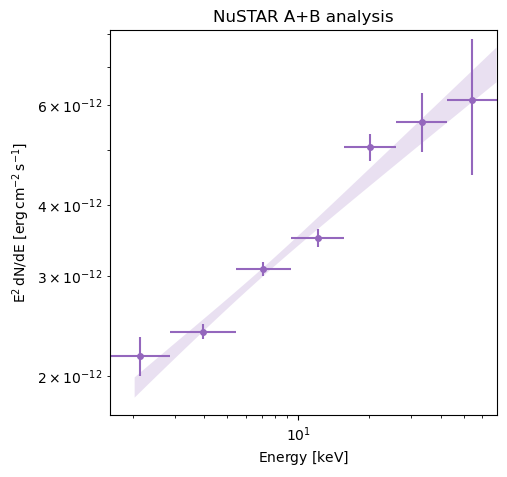

In [4]:
fig = plt.figure(figsize=(5, 5),dpi=100)

ax = nustar_only_model['OP313'].spectral_model.plot_error(
    [energy_edges[0],energy_edges[-1]],
    facecolor='C4',
    sed_type='e2dnde')

nustar_only_points.plot(
    ax=ax, color="C4", sed_type='e2dnde',
)
ax.set_title('NuSTAR A+B analysis')
ax.set_ylabel('$\mathrm{E^2\,dN/dE}$ $\mathrm{[erg\,cm^{-2}\,s^{-1}]}$')

#fig.savefig(f'{basedir}/Figures/MJD60373/NuSTAR/BestFit_NuSTAR.pdf')

In [5]:
nustar_datasets.models.parameters.free_parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link,prior
str1,str9,float64,str8,float64,float64,float64,bool,bool,str1,str1
,amplitude,6.3234e-04,s-1 cm-2,1.170e-05,1.000e-09,1.000e+06,False,True,,
,index,1.6295e+00,,2.994e-02,-2.000e+00,8.000e+00,False,False,,
,norm,7.3525e+02,,6.871e+01,nan,nan,False,True,,
,norm,9.1128e+02,,7.336e+01,nan,nan,False,True,,


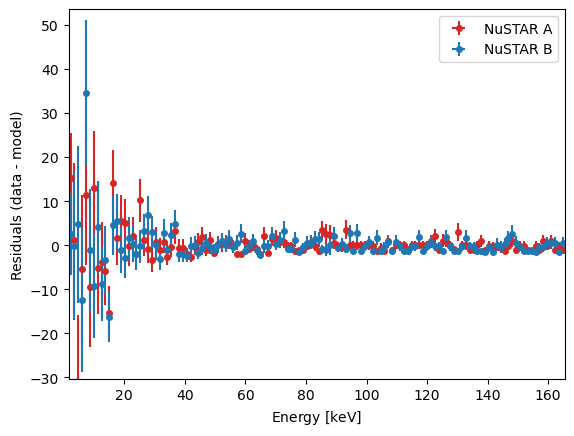

In [6]:
from regions import (
    CircleSkyRegion,
)
nustar_datasets[0].plot_residuals_spectral(
    color='tab:red',label='NuSTAR A',
)
nustar_datasets[1].plot_residuals_spectral(
    color='tab:blue',label='NuSTAR B',
)
plt.legend()